任务4
使用LetNet5，完成MNIST分类任务

# Setup

In [1]:
import torch
import numpy as np
import argparse
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Load and Batch the Data

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

def create_datasets(batch_size, valid_size=0.2, DIR='D:/datasets/'):
    # convert data to torch.FloatTensor
    transform = transforms.ToTensor()

    # choose the training and test datasets
    train_data = datasets.MNIST(root=DIR,
                                train=True,
                                download=False,
                                transform=transform)

    test_data = datasets.MNIST(root=DIR,
                               train=False,
                               download=False,
                               transform=transform)

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)

    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)

    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)

    return train_loader, test_loader, valid_loader

# Build Model

In [61]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.BatchNorm1d(120),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = LeNet()
print(model)

LeNet(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=84, out_features=10, bias=True)
  )
)


# Train the Model

In [62]:
optimizer = torch.optim.Adam(model.parameters())

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_accuracy = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        acc = pred.eq(target.view_as(pred)).sum().item() / args.batch_size
        train_accuracy += acc
        loss = args.criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), acc,
            ))
            if args.dry_run:
                break
    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)
    return train_loss, train_accuracy


def validate(args, model, device, val_loader):
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += args.criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            val_acc += pred.eq(target.view_as(pred)).sum().item() / args.batch_size
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    return val_loss, val_acc


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += args.criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_accuracy = correct / len(test_loader.dataset)

    return test_loss, test_accuracy


def get_args():
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=30, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')
    parser.add_argument('--criterion', default=nn.CrossEntropyLoss(),
                        help='loss function of training')
    args = parser.parse_args(args=[])
    return args
args = get_args()

class EarlyStop():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss, model):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif (self.best_loss - val_loss) > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif (self.best_loss - val_loss) < self.min_delta:
            print(f'INFO: Early stopping counter {self.counter+1} of {self.patience}')
            if self.counter == 0:
                print('Saving Model to ' + './models/LeNet.pth\n')
                torch.save(model, './models/LeNet.pth')
            self.counter += 1
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True
earlystop = EarlyStop()

def create_datasets(batch_size, valid_size=0.2, DIR='D:/datasets/'):
    # convert data to torch.FloatTensor
    transform = transforms.ToTensor()

    # choose the training and test datasets
    train_data = datasets.MNIST(root=DIR,
                                train=True,
                                download=False,
                                transform=transform)

    test_data = datasets.MNIST(root=DIR,
                               train=False,
                               download=False,
                               transform=transform)

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)

    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)

    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)

    return train_loader, test_loader, valid_loader


def main(args):
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    torch.manual_seed(args.seed)
    device = torch.device("cuda" if use_cuda else "cpu")
    train_loader, test_loader, val_loader = create_datasets(args.batch_size)

    model = LeNet().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
    train_history = {
        'train_loss': [],
        'train_acc': []
    }
    val_history = {
        'val_loss': [],
        'val_acc': [],
    }
    for epoch in range(1, args.epochs + 1):
        train_loss, train_acc = train(args, model, device, train_loader, optimizer, epoch)
        train_history['train_loss'].append(train_loss)
        train_history['train_acc'].append(train_acc)
        val_loss, val_acc = validate(args, model, device, val_loader)
        val_history['val_loss'].append(val_loss)
        val_history['val_acc'].append(val_acc)
        print('\nTrain Epoch: {}\tTrain Loss: {:.6f}\tTrain Accuracy: {:.6f}'
              '\n\t\t\tValidation Loss: {:.6f}\tValidation Accuracy: {:.6f}\n'.format(
              epoch, train_loss, train_acc, val_loss, val_acc
        ))
        earlystop(val_loss, model)
        if earlystop.early_stop:
            break
    model = torch.load('./models/LeNet.pth')
    test_loss, test_acc = test(args, model, device, test_loader)
    test_history = {
        'test_loss': test_loss,
        'test_acc': test_acc,
    }
    history = {
        'train_history': train_history,
        'val_history': val_history,
        'test_history': test_history,
    }

    if args.save_model:
        torch.save(model, './models/LeNet.pth')

    return history

history= main(args)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.409521	Accuracy: 0.093750
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.856177	Accuracy: 0.843750
Train Epoch: 1 [1280/60000 (3%)]	Loss: 0.474580	Accuracy: 0.890625
Train Epoch: 1 [1920/60000 (4%)]	Loss: 0.391048	Accuracy: 0.875000
Train Epoch: 1 [2560/60000 (5%)]	Loss: 0.274474	Accuracy: 0.921875
Train Epoch: 1 [3200/60000 (7%)]	Loss: 0.238262	Accuracy: 0.953125
Train Epoch: 1 [3840/60000 (8%)]	Loss: 0.200089	Accuracy: 0.937500
Train Epoch: 1 [4480/60000 (9%)]	Loss: 0.283686	Accuracy: 0.906250
Train Epoch: 1 [5120/60000 (11%)]	Loss: 0.130951	Accuracy: 0.968750
Train Epoch: 1 [5760/60000 (12%)]	Loss: 0.175452	Accuracy: 0.953125
Train Epoch: 1 [6400/60000 (13%)]	Loss: 0.304390	Accuracy: 0.906250
Train Epoch: 1 [7040/60000 (15%)]	Loss: 0.140452	Accuracy: 0.968750
Train Epoch: 1 [7680/60000 (16%)]	Loss: 0.111228	Accuracy: 0.953125
Train Epoch: 1 [8320/60000 (17%)]	Loss: 0.090731	Accuracy: 0.984375
Train Epoch: 1 [8960/60000 (19%)]	Loss: 0.285600	Accuracy: 0

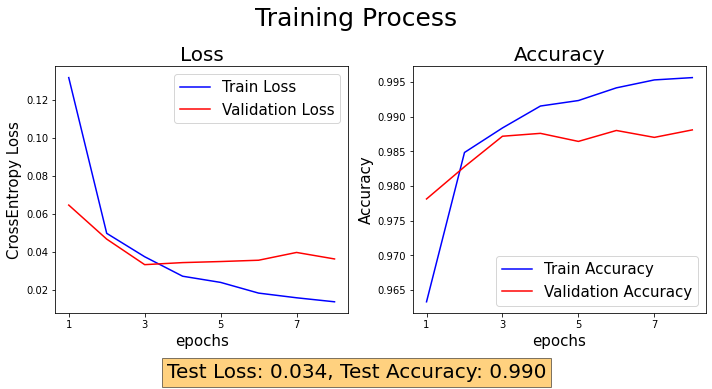

In [137]:
import matplotlib.pyplot as plt

def plot_res(history, PATH):
    train_history = history['train_history']
    val_history = history['val_history']
    test_history = history['test_history']

    plt.rcParams["figure.autolayout"] = True
    plt.rcParams["figure.figsize"] = [10, 5]
    plt.suptitle('Training Process', fontsize=25)

    epochs = [i+1 for i in range(len(train_history['train_loss']))]

    plt.subplot(121)
    plt.title('Loss', fontsize=20)
    plt.plot(epochs, train_history['train_loss'], color='blue')
    plt.plot(epochs, val_history['val_loss'], color='red')
    plt.legend(['Train Loss', 'Validation Loss'], loc='upper right', fontsize=15)
    plt.xticks(epochs[::2])
    plt.xlabel('epochs', fontsize=15)
    plt.ylabel('CrossEntropy Loss', fontsize=15)

    plt.subplot(122)
    plt.title('Accuracy', fontsize=20)
    plt.plot(epochs, train_history['train_acc'], color='blue')
    plt.plot(epochs, val_history['val_acc'], color='red')
    plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='best', fontsize=15)
    plt.xlabel('epochs', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.xticks(epochs[::2])
    plt.subplots_adjust(bottom=0.4)
    plt.figtext(0.5, -0.05, 'Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}'.format(**test_history), ha="center",
                fontsize=20, bbox={"facecolor": "orange", "alpha": 0.5, "pad": 5})

    plt.savefig(PATH, bbox_inches='tight')
    plt.show()

PATH = './imgs/LeNet.svg'
plot_res(history, PATH)